In [1]:
import pandas as pd
import numpy as np
import h2o
import lime
from lime import lime_tabular

from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.decomposition import PCA  # Principal component
from sklearn.linear_model import LinearRegression
from h2o.automl import H2OAutoML as ml

from functions.datacleaning import MoscowHousing as mh
from functions.clean import revert, write_predictions
from functions.distance import get_distance_coordinates, norm_features, PCA_plot

import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
XTrain = pd.read_csv("../prepared_data/train_prepared_category_3.csv")
XTest = pd.read_csv("../prepared_data/test_prepared_category_3.csv")

In [3]:
X_Train = XTrain.copy()
y_Train = XTrain["price"].copy()
y_Train = np.log(y_Train)  # use ln-scores to train

X_Test = XTest.copy()
drop_features = ["Unnamed: 0",
                 "id",
                 "street", 
                 "address"]
X_Train = X_Train.drop(drop_features, axis=1)
X_Train = X_Train.drop("price", axis=1)
X_Test = X_Test.drop(drop_features, axis=1)

In [4]:
X_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23285 entries, 0 to 23284
Data columns (total 87 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   area_total             23285 non-null  float64
 1   area_kitchen           23285 non-null  float64
 2   area_living            23285 non-null  float64
 3   floor                  23285 non-null  float64
 4   rooms                  23285 non-null  float64
 5   ceiling                23285 non-null  float64
 6   building_id            23285 non-null  int64  
 7   latitude               23285 non-null  float64
 8   longitude              23285 non-null  float64
 9   district               23285 non-null  int64  
 10  constructed            22491 non-null  float64
 11  stories                23285 non-null  float64
 12  distance               23285 non-null  float64
 13  distance_metro         23285 non-null  float64
 14  seller_0.0             23285 non-null  int64  
 15  se

In [5]:
# STACKING

# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('knn', KNeighborsRegressor()))
    level0.append(('cart', DecisionTreeRegressor()))
    level0.append(('svm', SVR()))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, 
                              final_estimator=level1, 
                              cv=5)
    return model


def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=5,
                       n_repeats= 3,
                       random_state=42)

    score = cross_val_score(model, X, y, 
                            scoring="neg_mean_absolute_error", 
                            cv=cv,
                            n_jobs=-1,
                            error_score="raise")
    return score

def get_models():
    models = {}
    
    models["knn"] = KNeighborsRegressor()
    
    models["lgbm"] = lgb.LGBMRegressor(num_leaves=25,
                                       max_depth=15, 
                                       random_state=42,
                                       metric='mse',
                                       n_jobs=4, 
                                       n_estimators=3000,
                                       colsample_bytree=0.7,
                                       subsample=0.9,
                                       learning_rate=0.05)
    
    models["cat"] = CatBoostRegressor(n_estimators=1000,
                                      learning_rate=0.008,
                                      thread_count=-1,
                                      depth=7,
                                      silent=True,
                                      random_seed=42,
                                      bagging_temperature=0.2)
    
    models["rf"] = RandomForestRegressor(n_estimators=1000,
                                         criterion='mse',
                                         max_depth=None,
                                         #min_samples_split=2,
                                         #min_samples_leaf=2,
                                         min_weight_fraction_leaf=0.0,
                                         max_features='auto',
                                         max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                                         bootstrap=True,
                                         oob_score=False,
                                         n_jobs=None,
                                         random_state=42,
                                         verbose=0,
                                         warm_start=False,
                                         ccp_alpha=0.0,
                                         max_samples=None)
    
    # models['stacking'] = get_stacking()
    
    return models

In [6]:
y = y_Train.copy()
X = X_Train.copy()

X = X.drop(["constructed"], axis=1)

models = get_models()

for k, o in models.items():

    print(k)
    print(o)


knn
KNeighborsRegressor()
lgbm
LGBMRegressor(colsample_bytree=0.7, learning_rate=0.05, max_depth=15,
              metric='mse', n_estimators=3000, n_jobs=4, num_leaves=25,
              random_state=42, subsample=0.9)
cat
rf
RandomForestRegressor(n_estimators=1000, random_state=42)


>knn -0.344 (0.006)
>lgbm -0.133 (0.002)
>cat -0.203 (0.002)
>rf -0.157 (0.002)


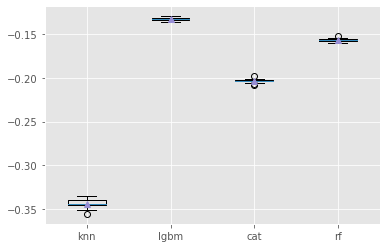

In [7]:
results = []
names = []
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [8]:
from sklearn.ensemble import StackingRegressor